# RoadMap 15 - Classification 2 - Training & Validating [Custom CNN, Public Dataset]

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# Steps to take

1. Create a network
    - Arrange layers
    - Visualize layers
    - Creating loss function module
    - Creating optimizer module [Set learning rates here]
    
    
2. Data prepraration
    - Creating a data transformer
    - Downloading public dataset and applying transformation
    - Understanding dataset
    - Loading the transformed dataset [Set batch size and number of parallel processors here]
    
    
3. Setting up data - plotters


4. Training
    - Set Epoch
    - Train model
    
    
5. Validating
    - Overall-accuracy validation
    - Class-wise accuracy validation

    

In [2]:
# 1.1 Creating a custom neural network
import torch.nn as nn
import torch.nn.functional as F

'''
Network arrangement

    Input -> Conv1 -> Relu -> Pool -> Conv2 -> Relu -> Pool -> FC1 -> Relu -> FC2 -> Relu -> FC3 -> Output 

'''


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU() # Activation function
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # In-channels, Out-Channels
        self.fc2 = nn.Linear(120, 84) # In-channels, Out-Channels
        self.fc3 = nn.Linear(84, 10) # In-channels, Out-Channels

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [3]:
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [4]:
# 1.2 Visualizing network
from torchsummary import summary
print("Network - ")
summary(net, (3, 32, 32))

Network - 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.24
Estimated Total Size (MB): 0.36
----------------------------------

In [5]:
# 1.3. Creating loss function module
cross_entropy_loss = nn.CrossEntropyLoss()


In [6]:
# 1.4. Creating optimizer module

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# 2.1. Creating data trasnformer

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
# 2.2. Downloading public dataset and applying transformations simultaneously


# Download CIFAR10 Training Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


# Download CIFAR10 Testing Dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


0it [00:00, ?it/s]

100%|█████████▉| 169779200/170498071 [00:16<00:00, 13265642.21it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
print("Train dataset - ", dir(trainset))
print("\n")
print("Test dataset - ", dir(testset))

Train dataset -  ['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_integrity', '_format_transform_repr', '_load_meta', '_repr_indent', 'base_folder', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'filename', 'meta', 'root', 'target_transform', 'targets', 'test_list', 'tgz_md5', 'train', 'train_list', 'transform', 'transforms', 'url']


Test dataset -  ['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex_

In [17]:
# 2.3. - Understanding dataset

print("Number of training images - ", len(trainset.data))
print("Number of testing images - ", len(testset.data))
print("Size of images - ", trainset.data[0].shape)

Number of training images -  50000
Number of testing images -  10000
Size of images -  (32, 32, 3)


In [19]:
# 2.4. - Loading the transformed dataset

batch = 4
parallel_processors = 3

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True, num_workers=parallel_processors)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=parallel_processors)

# Class list
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

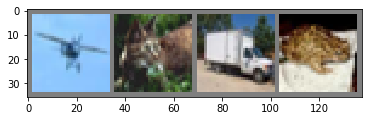

tensor([0, 3, 9, 6])
plane   cat truck  frog


In [21]:
# 3. Setting up data plotters

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
print(labels)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
from tqdm.notebook import tqdm

In [27]:
# 4. Training

num_epochs = 2

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    pbar = tqdm(total=len(trainloader))
    for i, data in enumerate(trainloader):
        pbar.update();
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.869
[1,  4000] loss: 1.708
[1,  6000] loss: 1.599
[1,  8000] loss: 1.521
[1, 10000] loss: 1.460
[1, 12000] loss: 1.402


[2,  2000] loss: 1.344
[2,  4000] loss: 1.280
[2,  6000] loss: 1.297
[2,  8000] loss: 1.276
[2, 10000] loss: 1.247
[2, 12000] loss: 1.205
Finished Training


In [30]:
# 5.1 Overall-accuracy Validation 
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [31]:
# 5.2 Classwise-accuracy Validation
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 75 %
Accuracy of  bird : 35 %
Accuracy of   cat : 45 %
Accuracy of  deer : 51 %
Accuracy of   dog : 44 %
Accuracy of  frog : 67 %
Accuracy of horse : 65 %
Accuracy of  ship : 74 %
Accuracy of truck : 59 %


## Author - Tessellate Imaging - https://www.tessellateimaging.com/

## Monk Library - https://github.com/Tessellate-Imaging/monk_v1

    Monk is an opensource low-code tool for computer vision and deep learning

### Monk features
- low-code
- unified wrapper over major deep learning framework - keras, pytorch, gluoncv
- syntax invariant wrapper


### Enables
- to create, manage and version control deep learning experiments
- to compare experiments across training metrics
- to quickly find best hyper-parameters


### At present it only supports transfer learning, but we are working each day to incorporate
- GUI based custom model creation
- various object detection and segmentation algorithms
- deployment pipelines to cloud and local platforms
- acceleration libraries such as TensorRT
- preprocessing and post processing libraries

## To contribute to Monk AI or Pytorch RoadMap repository raise an issue in the git-repo or dm us on linkedin 
 - Abhishek - https://www.linkedin.com/in/abhishek-kumar-annamraju/
 - Akash - https://www.linkedin.com/in/akashdeepsingh01/